## CSV to midi

### Setup

In [184]:
import pandas as pd
import numpy as np
import pretty_midi
import fluidsynth
from IPython import display
import glob
import collections
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
filenames = glob.glob('raw_data/mozart_sonatas/mps - K*')
print('Number of files:', len(filenames))
print('first file:', filenames[0])

Number of files: 57
first file: raw_data/mozart_sonatas/mps - K311-I.csv


**create pieces df (each row is one piece)**

In [3]:
pieces_df = pd.read_csv('raw_data/mozart_sonatas/mps - pieces.csv')
pieces_df.head()

name      key  title time_sig        tempo marking    bpm  pickup_bar  \
0    K545-I  c major    NaN   common              allegro  4=132           0   
1   K545-II  g major    NaN      3/4              andante   4=60           0   
2  K545-III  c major  Rondo      2/4  allegretto grazioso  4=104           1   
3    K283-I  g major    NaN      3/4              allegro  4=138           1   
4   K283-II  c major    NaN   common              andante   4=58           0   

  pickup_length  
0             0  
1             0  
2             4  
3             4  
4             0

### Normalize pitches to C major / A minor

**create key converter dictionaries**

In [4]:
all_keys = set([key for key in pieces_df.key.value_counts().index])
all_keys

{'a major',
 'a minor',
 'bb major',
 'c major',
 'c minor',
 'd major',
 'eb major',
 'f major',
 'f minor',
 'g major'}

In [5]:
# key: # of half steps to add to get to c major / a minor
maj_key_converter_dict = {'a major': 3, 'bb major': 2, 'c major': 0, 'd major': -2, 'eb major': -3, 'f major': -5, 'g major': 5}
min_key_converter_dict = {'a minor': 0, 'c minor': -3, 'f minor': 4}

In [27]:
def normalize_pitches(x, piece_key_type, piece_key):
    if x > 0:
        if piece_key_type == 'major':
            x += maj_key_converter_dict[piece_key]
        else:
            x += min_key_converter_dict[piece_key]
    return x

### Create duration (in seconds) column

In [14]:
bpm_beat_types = set([bpm.split('=')[0] for bpm in pieces_df.bpm.value_counts().index])
bpm_beat_types

{'2', '2d', '4', '4d', '8'}

In [15]:
# bpm note value: amount to multiply bpm by to convert bpm to quarter notes
bpm_converter_dict = {'2': 2, '2d': 3, '4': 1, '4d': 1.5, '8': 0.5}

In [16]:
# duration: amount to multiply spb (seconds per beat) by to get duration in seconds
beat_dict = {
    '1': 4, 
    '2': 2, 
    '4': 1, 
    '8': 0.5,
    '16': 0.25,
    '32': 0.125,
    '64': 0.0625
}

In [35]:
def duration_to_seconds(x, piece_spb):
    if type(x) != 'str':
        x = str(x)
    if x[-2:] == 'dd':
        s = piece_spb * beat_dict[x[:-2]] * 1.75
    elif x[-1] == 'd':
        s = piece_spb * beat_dict[x[:-1]] * 1.5
    else:
        s = piece_spb * beat_dict[x]
    return s

### preprocess all dfs

In [38]:
def process_df(filename):
    
    # extract the K number
    k_num = filename.split(' - ')[1].split('.csv')[0].strip(' ')
    
    # create df
    df = pd.read_csv(filename)  # make df
    
    # normalize pitch
    df['pitch'] = df.note_name.apply(lambda x: pretty_midi.note_name_to_number(x) if x != 'r' else 0)  
    piece_key = pieces_df[pieces_df['name'] == k_num]['key'].values[0].strip(' ')
    piece_key_type = piece_key.split(' ')[1].strip(' ')
    df['pitch_norm'] = df.pitch.apply(normalize_pitches, args=(piece_key_type, piece_key))
    
    # get duration in seconds
    piece_bpm = pieces_df[pieces_df['name'] == k_num]['bpm'].values[0].split('=')
    piece_bpm_norm = int(bpm_converter_dict[piece_bpm[0]] * int(piece_bpm[1]))
    piece_spb = 60 / piece_bpm_norm
    df['dur(s)'] = df.duration.apply(duration_to_seconds, args=(piece_spb,))
    
    return df

In [64]:
all_csv_dfs = []
for file in filenames:
    all_csv_dfs.append(process_df(file))

In [65]:
all_csv_dfs[0].head()

note_name  duration  measure  beat  subdiv harm  from_root  NCT  BI2  CI  \
0        d5         4        1     1       1    I          1    0    0   0   
1         r         4        1     2       1    0          0    0    0   0   
2        g5        16        1     3       1    I          4    1    0   0   
3       f#5        16        1     3       2    I          3    0    0   0   
4        e5        16        1     3       3    I          2    1    0   0   

   trill dynamic  pitch  pitch_norm    dur(s)  
0      0       f     74          72  0.454545  
1      0       f      0           0  0.454545  
2      0       f     79          77  0.113636  
3      0       f     78          76  0.113636  
4      0       f     76          74  0.113636

### Create midi file

In [41]:
def notes_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start)
        end = float(prev_start + note['dur(s)'])
        if note['note_name'] == 'r':
            start += float(note['dur(s)'])
            prev_start = start
        else:
            note = pretty_midi.Note(
                velocity=velocity,
                pitch=int(pretty_midi.note_name_to_number(note['note_name'])),
                start=start,
                end=end
            )
            instrument.notes.append(note)
            prev_start = end
            
    pm.instruments.append(instrument)
    return pm

In [66]:
instrument_name = 'Acoustic Guitar (nylon)'

all_midis = []
for df in all_csv_dfs:
    pm = notes_to_midi(df, instrument_name)
    all_midis.append(pm)

### Playback the midi

In [42]:
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [60]:
# instrument_name = 'Electric Piano 1'
instrument_name = 'Acoustic Guitar (nylon)'
out_file = 'example.midi'

example_pm = notes_to_midi(all_dfs[10], instrument_name)

In [61]:
display_audio(example_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


### Create dataframe from midi

In [62]:
instrument = example_pm.instruments[0]
instrument.notes

[Note(start=0.000000, end=0.129310, pitch=79, velocity=100),
 Note(start=0.129310, end=0.258621, pitch=77, velocity=100),
 Note(start=0.258621, end=0.387931, pitch=75, velocity=100),
 Note(start=0.387931, end=0.517241, pitch=74, velocity=100),
 Note(start=0.517241, end=0.775862, pitch=72, velocity=100),
 Note(start=0.775862, end=1.034483, pitch=70, velocity=100),
 Note(start=1.034483, end=1.810345, pitch=70, velocity=100),
 Note(start=1.810345, end=2.068966, pitch=74, velocity=100),
 Note(start=2.068966, end=2.327586, pitch=79, velocity=100),
 Note(start=2.327586, end=2.586207, pitch=74, velocity=100),
 Note(start=2.586207, end=3.103448, pitch=77, velocity=100),
 Note(start=3.103448, end=3.879310, pitch=75, velocity=100),
 Note(start=3.879310, end=4.008621, pitch=77, velocity=100),
 Note(start=4.008621, end=4.137931, pitch=79, velocity=100),
 Note(start=4.137931, end=4.267241, pitch=77, velocity=100),
 Note(start=4.267241, end=4.396552, pitch=75, velocity=100),
 Note(start=4.396552, en

In [63]:
def midi_to_notes(midi: pretty_midi.PrettyMIDI()) -> pd.DataFrame:
#     pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = midi.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end - start)
        prev_start = start
        
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [67]:
all_midi_dfs = []

for midi in all_midis:
    midi_df = midi_to_notes(midi)
    all_midi_dfs.append(midi_df)

In [70]:
all_midi_dfs[45].head()

pitch    start       end     step  duration
0      71  0.00000   0.62500  0.00000   0.62500
1      72  0.62500   1.09375  0.62500   0.46875
2      71  1.09375   1.25000  0.46875   0.15625
3      69  1.25000   1.87500  0.15625   0.62500
4      71  1.87500   2.50000  0.62500   0.62500
5      72  2.50000   3.12500  0.62500   0.62500
6      74  3.12500   3.75000  0.62500   0.62500
7      72  3.75000   4.06250  0.62500   0.31250
8      71  4.06250   4.37500  0.31250   0.31250
9      69  4.37500   4.68750  0.31250   0.31250
10     67  4.68750   5.00000  0.31250   0.31250
11     72  5.00000   5.62500  0.31250   0.62500
12     71  5.62500   6.25000  0.62500   0.62500
13     76  6.25000   6.87500  0.62500   0.62500
14     74  7.18750   7.50000  0.93750   0.31250
15     72  7.50000   7.81250  0.31250   0.31250
16     69  7.81250   8.12500  0.31250   0.31250
17     71  8.12500   8.43750  0.31250   0.31250
18     67  8.43750   8.75000  0.31250   0.31250
19     71  8.75000   9.37500  0.31250   0.62500
20     69  9.37500  10.00000  0.62500   0.62500

In [91]:
max_pitch_list = []
min_pitch_list = []
pitch_list = []
for midi in all_midi_dfs:
    max_pitch_list.append(midi.pitch.max())
    min_pitch_list.append(midi.pitch.min())
    for pitch in midi.pitch:
        if pitch not in pitch_list:
            pitch_list.append(pitch)

In [101]:
pitch_list.sort()
print(f"highest note: {max(max_pitch_list)} ({pretty_midi.note_number_to_name(max(max_pitch_list))})")
print(f"lowest note:, {min(min_pitch_list)} ({pretty_midi.note_number_to_name(min(min_pitch_list))})")
print('number of different notes:', len(pitch_list))

highest note: 89 (F6)
lowest note:, 57 (A3)
number of different notes: 31


### Create slices

In [109]:
num_slices_per_midi = 5
slice_length = 4
X = []
y = []

for midi in all_midi_dfs:
    df_len = len(midi)
    last_possible_ind = df_len - (slice_length + 1)
    slice_ind = np.random.choice(last_possible_ind, num_slices_per_midi, replace=False)
    for i in slice_ind:
        X.append(midi.loc[i:i+(slice_length - 1)])
        y.append(midi.loc[i+slice_length])


In [140]:
X[0].values

array([[83.        ,  2.95454545,  3.18181818,  0.22727273,  0.22727273],
       [85.        ,  3.18181818,  3.40909091,  0.22727273,  0.22727273],
       [86.        ,  3.40909091,  3.63636364,  0.22727273,  0.22727273],
       [81.        ,  3.63636364,  4.09090909,  0.22727273,  0.45454545]])

In [150]:
X_seq = []
for slice in X:
    X_seq.append(np.delete(slice.values, [1,2], axis=1))

In [155]:
X_3d = np.stack(X_seq)

In [162]:
y_seq = []
for slice in y:
    y_seq.append(np.delete(slice.values, [1,2]))

In [163]:
y_2d = np.stack(y_seq)

In [164]:
print(X_3d.shape)
print(y_2d.shape)

(285, 4, 3)
(285, 3)


### Simple model

In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()
    model.add(layers.LSTM(units=len(pitch_list), activation='tanh', input_shape=X_3d.shape[1:]))
    model.add(layers.Dense(3, activation='linear'))
    
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [198]:
model = initialize_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 31)                4340      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 96        
Total params: 4,436
Trainable params: 4,436
Non-trainable params: 0
_________________________________________________________________


In [199]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

model = initialize_model()
history = model.fit(X_3d, y_2d, validation_split=0.3, batch_size=16, epochs=300, verbose=1, callbacks=[es])

Epoch 1/300
13/13 [==============================] - 1s 45ms/step - loss: 1729.6923 - val_loss: 1753.5903
Epoch 2/300
13/13 [==============================] - 0s 7ms/step - loss: 1697.7572 - val_loss: 1725.3563
Epoch 3/300
13/13 [==============================] - 0s 7ms/step - loss: 1670.4031 - val_loss: 1692.3192
Epoch 4/300
13/13 [==============================] - 0s 6ms/step - loss: 1628.2181 - val_loss: 1639.0721
Epoch 5/300
13/13 [==============================] - 0s 6ms/step - loss: 1569.8296 - val_loss: 1575.6243
Epoch 6/300
13/13 [==============================] - 0s 6ms/step - loss: 1500.4711 - val_loss: 1497.7148
Epoch 7/300
13/13 [==============================] - 0s 5ms/step - loss: 1436.5270 - val_loss: 1456.4257
Epoch 8/300
13/13 [==============================] - 0s 5ms/step - loss: 1408.3137 - val_loss: 1435.9521
Epoch 9/300
13/13 [==============================] - 0s 5ms/step - loss: 1390.3845 - val_loss: 1419.1327
Epoch 10/300
13/13 [==============================] - 

13/13 [==============================] - 0s 5ms/step - loss: 533.9830 - val_loss: 551.4601
Epoch 80/300
13/13 [==============================] - 0s 5ms/step - loss: 524.7910 - val_loss: 542.0942
Epoch 81/300
13/13 [==============================] - 0s 5ms/step - loss: 515.7017 - val_loss: 532.8483
Epoch 82/300
13/13 [==============================] - 0s 5ms/step - loss: 506.6884 - val_loss: 523.6780
Epoch 83/300
13/13 [==============================] - 0s 5ms/step - loss: 497.7386 - val_loss: 514.5294
Epoch 84/300
13/13 [==============================] - 0s 5ms/step - loss: 488.8999 - val_loss: 505.5387
Epoch 85/300
13/13 [==============================] - 0s 5ms/step - loss: 480.1321 - val_loss: 496.5590
Epoch 86/300
13/13 [==============================] - 0s 5ms/step - loss: 471.4010 - val_loss: 487.6684
Epoch 87/300
13/13 [==============================] - 0s 6ms/step - loss: 462.7706 - val_loss: 478.9136
Epoch 88/300
13/13 [==============================] - 0s 6ms/step - loss: 454

13/13 [==============================] - 0s 6ms/step - loss: 61.9963 - val_loss: 66.3156
Epoch 158/300
13/13 [==============================] - 0s 7ms/step - loss: 59.1577 - val_loss: 63.2979
Epoch 159/300
13/13 [==============================] - 0s 6ms/step - loss: 56.3727 - val_loss: 60.3434
Epoch 160/300
13/13 [==============================] - 0s 6ms/step - loss: 53.6647 - val_loss: 57.4851
Epoch 161/300
13/13 [==============================] - 0s 6ms/step - loss: 51.0589 - val_loss: 54.6981
Epoch 162/300
13/13 [==============================] - 0s 6ms/step - loss: 48.5127 - val_loss: 52.0180
Epoch 163/300
13/13 [==============================] - 0s 6ms/step - loss: 46.0775 - val_loss: 49.4247
Epoch 164/300
13/13 [==============================] - 0s 6ms/step - loss: 43.7186 - val_loss: 46.8740
Epoch 165/300
13/13 [==============================] - 0s 5ms/step - loss: 41.4166 - val_loss: 44.3811
Epoch 166/300
13/13 [==============================] - 0s 5ms/step - loss: 39.1932 - va

13/13 [==============================] - 0s 7ms/step - loss: 8.5322 - val_loss: 6.7185
Epoch 238/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5339 - val_loss: 6.7044
Epoch 239/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5312 - val_loss: 6.7055
Epoch 240/300
13/13 [==============================] - 0s 9ms/step - loss: 8.5372 - val_loss: 6.6971
Epoch 241/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5370 - val_loss: 6.6864
Epoch 242/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5331 - val_loss: 6.7082
Epoch 243/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5416 - val_loss: 6.7063
Epoch 244/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5390 - val_loss: 6.7051
Epoch 245/300
13/13 [==============================] - 0s 6ms/step - loss: 8.5329 - val_loss: 6.7396
Epoch 246/300
13/13 [==============================] - 0s 5ms/step - loss: 8.5392 - val_loss: 6.7370
Epoc

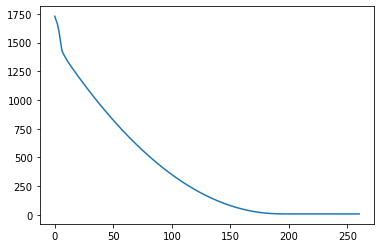

In [200]:
plt.plot(history.epoch, history.history['loss'])

In [213]:
y_pred[0][0]

73.155174

In [225]:
X_test = tf.expand_dims(X_3d[0], 0)

y_pred = model.predict(X_test)

y_pred

array([[73.155174  ,  0.39351708,  0.33553022]], dtype=float32)

### Generate Notes

In [226]:
number_predictions = 20

input_notes = X_3d[0]

generated_notes = []
prev_start = 0
for i in range(number_predictions):
    inputs = tf.expand_dims(input_notes, 0)
    y_pred = model.predict(inputs)
    pitch = int(y_pred[0][0])
    step = y_pred[0][1]
    duration = y_pred[0][2]
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
    

In [227]:
generated_notes = pd.DataFrame(generated_notes, columns=all_midi_dfs[0].columns)

In [228]:
generated_notes

pitch     start      end      step  duration
0      73  0.393517  0.33553  0.393517  0.729047
1      73  0.393517  0.33553  0.787034  1.122564
2      73  0.393517  0.33553  1.180551  1.516081
3      73  0.393517  0.33553  1.574068  1.909599
4      73  0.393517  0.33553  1.967585  2.303116
5      73  0.393517  0.33553  2.361102  2.696633
6      73  0.393517  0.33553  2.754620  3.090150
7      73  0.393517  0.33553  3.148137  3.483667
8      73  0.393517  0.33553  3.541654  3.877184
9      73  0.393517  0.33553  3.935171  4.270701
10     73  0.393517  0.33553  4.328688  4.664218
11     73  0.393517  0.33553  4.722205  5.057735
12     73  0.393517  0.33553  5.115722  5.451252
13     73  0.393517  0.33553  5.509239  5.844769
14     73  0.393517  0.33553  5.902756  6.238286
15     73  0.393517  0.33553  6.296273  6.631803
16     73  0.393517  0.33553  6.689790  7.025321
17     73  0.393517  0.33553  7.083307  7.418838
18     73  0.393517  0.33553  7.476824  7.812355
19     73  0.393517  0.33553  7.870342  8.205872

In [233]:
def midi_df_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start
        
    pm.instruments.append(instrument)
    return pm

In [235]:
pm = midi_df_to_midi(generated_notes, instrument_name)
display_audio(pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


### from RNN tutorial

In [166]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true -y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [170]:
input_shape = X_3d.shape[1:]
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(len(pitch_list))(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(len(pitch_list), name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}
                                   

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 31)           4340        input_2[0][0]                    
__________________________________________________________________________________________________
duration (Dense)                (None, 1)            32          lstm_1[0][0]                     
__________________________________________________________________________________________________
pitch (Dense)                   (None, 31)           992         lstm_1[0][0]                     
_______________________________________________________________________________________

In [174]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0
    },
    optimizer=optimizer,
)


In [175]:
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True)

In [177]:
%%time
epochs = 10

history = model.fit(
    X_3d,
    epochs=epochs,
    callbacks=[es],
)

Epoch 1/10


ValueError: in user code:

    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:801 train_function  *
        return step_function(self, iterator)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:791 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:784 run_step  **
        outputs = model.train_step(data)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:751 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2734 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['lstm_1/lstm_cell_1/kernel:0', 'lstm_1/lstm_cell_1/recurrent_kernel:0', 'lstm_1/lstm_cell_1/bias:0', 'duration/kernel:0', 'duration/bias:0', 'pitch/kernel:0', 'pitch/bias:0', 'step/kernel:0', 'step/bias:0'].


### dataframes to tensorflow dataset

In [78]:
key_order = ['pitch', 'step', 'duration']

midi_arrays = []
for df in all_midi_dfs:
    midi_arrays.append(np.stack([df[key] for key in key_order], axis=1))

In [83]:
tf_stuff = []
for array in midi_arrays:
    tf_stuff.append(tf.data.Dataset.from_tensor_slices(array))

In [85]:
list(tf_stuff[0].as_numpy_iterator())

[array([74.        ,  0.        ,  0.45454545]),
 array([79.        ,  0.90909091,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([76.        ,  0.11363636,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([81.        ,  0.11363636,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([81.        ,  0.11363636,  0.45454545]),
 array([81.        ,  0.90909091,  0.22727273]),
 array([83.        ,  0.22727273,  0.22727273]),
 array([85.        ,  0.22727273,  0.22727273]),
 array([86.        ,  0.22727273,  0.22727273]),
 array([81.        ,  0.22727273,  0.45454545]),
 array([78.        ,  0.45454545,  0.45454545]),
 array([81.        ,  0.45454545,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([81.        ,

### create slices

### Useful code

In [ ]:
# df['dur(s)'] = df.duration.apply(compound_duration_to_seconds)

In [ ]:
# prev_start = 0
# start = []
# end = []
# for _ in df['dur(s)']:
#     start.append(prev_start)
#     end_time = prev_start + _
#     end.append(end_time)
#     prev_start = end_time

In [ ]:
# df['start'] = pd.Series(start)
# df['end'] = pd.Series(end)
# df['pitch'] = df['note_name'].apply(lambda x: pretty_midi.note_name_to_number(x))